In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

from counterfactuals.cf_methods import PPCEF
from counterfactuals.datasets.file_dataset import FileDataset
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.metrics.orchestrator import MetricsOrchestrator
from counterfactuals.models import MaskedAutoregressiveFlow
from counterfactuals.models.classifier.multilayer_perceptron import MLPClassifier
from counterfactuals.plotting.counterfactual_visualization import plot_counterfactuals

METRICS_CONF_PATH = "../config/metrics/plausibility.yaml"

np.random.seed(42)
torch.manual_seed(42)

/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Prepare the data
dataset = FileDataset(config_path="config/datasets/moons.yaml")

# Get the split data that's already available
X_train = dataset.X_train
X_test = dataset.X_test
y_train = dataset.y_train
y_test = dataset.y_test

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# Train a discriminative model
num_inputs = X_train.shape[1]
num_targets = 1

In [4]:
discriminative_model = MLPClassifier(
    num_inputs, num_targets, [128, 128, 128], dropout=0.0
)
discriminative_model.fit(
    train_dataloader,
    test_dataloader,
    epochs=5000,
    patience=300,
    lr=1e-3,
)

Epoch 430, Train: 0.0038, test: 0.0021, patience: 300:   9%|▊         | 431/5000 [00:09<01:38, 46.17it/s]


In [5]:
# Train a generative model
num_inputs = X_train.shape[1]
num_targets = 1

generative_model = MaskedAutoregressiveFlow(
    features=num_inputs,
    hidden_features=128,
    context_features=num_targets,
)
generative_model.fit(
    train_dataloader, test_dataloader, epochs=100, patience=600, lr=0.01
)
log_prob_threshold = np.median(generative_model.predict_log_prob(test_dataloader))

Epoch 99, Train: 0.5931, test: 0.6445, patience: 17: 100%|██████████| 100/100 [00:12<00:00,  7.91it/s]  


In [6]:
X_test_orig = X_test[y_test == 0]
y_test_orig = y_test[y_test == 0]

cf_dataset = TensorDataset(
    torch.tensor(X_test_orig, dtype=torch.float32),
    torch.tensor(y_test_orig, dtype=torch.float32),
)

# Method 1: PPCEF (Probabilistically Plausible Counterfactual Explanations using Normalizing Flows)

## Reference
Wielopolski, P., Furman, O., Stefanowski, J., & Zięba, M. (2024). *Probabilistically Plausible Counterfactual Explanations with Normalizing Flows*. IOS Press. DOI: [10.3233/FAIA240584](https://doi.org/10.3233/FAIA240584)

## Description
PPCEF is a novel method for generating probabilistically plausible counterfactual explanations. This approach utilizes **normalizing flows** (specifically Masked Autoregressive Flows) as density estimators within an unconstrained optimization framework. The method effectively balances three key objectives:
- **Distance**: Minimizing the change from the original instance
- **Validity**: Ensuring the counterfactual achieves the desired prediction
- **Probabilistic plausibility**: Ensuring the counterfactual lies in high-density regions of the data distribution

The method is particularly notable for its computational efficiency and ability to process large and high-dimensional datasets, making it applicable in real-world scenarios.

## Mathematical Formulation

The PPCEF optimization problem can be formulated as:

$$
\min_{\delta} \mathcal{L}_{\text{disc}}(f(x + \delta), y_{\text{target}}) + \alpha \cdot \max(0, \tau - \log p_{\theta}(x + \delta | y_{\text{target}}))
$$

where:
- $\delta$ is the perturbation vector to be optimized
- $x$ is the original input instance
- $f$ is the discriminative model (classifier)
- $y_{\text{target}}$ is the desired target class
- $\mathcal{L}_{\text{disc}}$ is the discriminative loss (e.g., binary cross-entropy)
- $p_{\theta}(x | y)$ is the conditional density estimated by the normalizing flow
- $\tau$ is the log-probability threshold (plausibility threshold)
- $\alpha$ is the hyperparameter controlling the trade-off between validity and plausibility

The counterfactual is then: $x_{cf} = x + \delta$

The plausibility constraint ensures that the generated counterfactual has a log-probability above the threshold $\tau$, typically set to a quantile (e.g., 25th percentile) of the training data log-probabilities.


In [7]:
cf_dataloader = DataLoader(cf_dataset, batch_size=1024, shuffle=False)


cf_method = PPCEF(
    disc_model=discriminative_model,
    gen_model=generative_model,
    disc_model_criterion=BinaryDiscLoss(),
)

results = cf_method.explain_dataloader(
    cf_dataloader,
    alpha=100,
    log_prob_threshold=log_prob_threshold,
    epochs=5000,
    patience=600,
    lr=0.001,
)

Discriminator loss: 0.0000, Prob loss: 0.0185: 100%|██████████| 5000/5000 [00:13<00:00, 376.59it/s]


In [ ]:
ys_target = np.abs(1 - y_test_orig)


metrics_cf = MetricsOrchestrator(
    disc_model=discriminative_model,
    gen_model=generative_model,
    X_cf=results.x_cfs,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test_orig,
    y_test=y_test_orig,
    y_target=ys_target,
    continuous_features=[0, 1],
    categorical_features=[],
    ratio_cont=None,
    prob_plausibility_threshold=log_prob_threshold,
    metrics_conf_path=METRICS_CONF_PATH,
)
metrics = metrics_cf.calculate_all_metrics()

2025-10-17 11:27:06,889 - counterfactuals.metrics.orchestrator - INFO - Initialized MetricsOrchestrator with 99 counterfactuals, 87 valid


In [10]:
metrics

{'coverage': 1.0,
 'validity': 0.8787878787878788,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': 1.5799133295039092,
 'proximity_categorical_jaccard': 1.5799133295039092,
 'proximity_continuous_manhattan': 2.0859332284610304,
 'proximity_continuous_euclidean': 1.5799133295039092,
 'proximity_continuous_mad': 4.330640959313685,
 'proximity_l2_jaccard': 1.5799133295039092,
 'proximity_mad_hamming': 4.330640959313685,
 'prob_plausibility': 0.20202020202020202,
 'log_density_cf': -4.215533,
 'log_density_test': -0.5425421,
 'lof_scores_cf': 1.4248940890271868,
 'lof_scores_test': 1.0721709410716256,
 'isolation_forest_scores_cf': -0.038821234332785066,
 'isolation_forest_scores_test': 0.00497389017100576}

/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/.venv/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


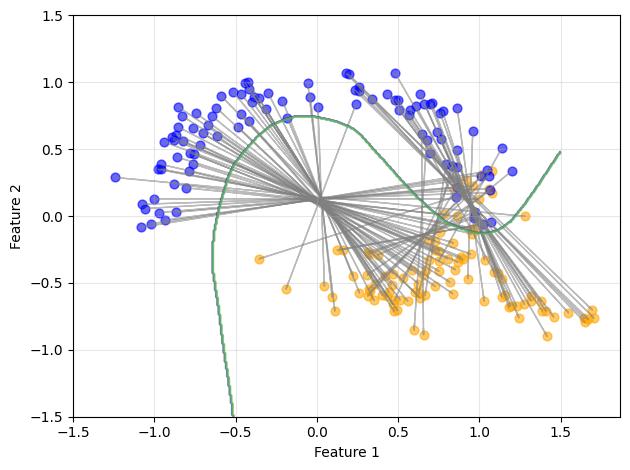

In [11]:
plot_counterfactuals(
    X_test_orig,
    results.x_cfs,
    generative_model,
    discriminative_model,
    region_area_x=[-1.5, 1.5],
    region_area_y=[-1.5, 1.5],
)

# Method 2: CCHVAE (Conditional Counterfactual Hierarchical Variational Autoencoder)

## Reference
Pawelczyk, M., Broelemann, K., & Kasneci, G. (2020). *Learning Model-Agnostic Counterfactual Explanations for Tabular Data*. In *Proceedings of The Web Conference 2020* (WWW '20). ACM. DOI: [10.1145/3366423.3380087](https://doi.org/10.1145/3366423.3380087)

## Description
CCHVAE is a model-agnostic method for generating counterfactual explanations using a **Variational Autoencoder (VAE)** as a generative model. The key idea is to learn a low-dimensional latent representation of the data distribution and then search for counterfactuals in this latent space.

The method operates in two main phases:
1. **VAE Training**: A VAE is trained on the dataset to learn a compressed latent representation that captures the data distribution
2. **Counterfactual Search**: For each instance, the method:
   - Encodes the instance into the latent space
   - Samples points on expanding hyperspheres around the latent representation
   - Decodes these points back to the original feature space
   - Evaluates them using the black-box classifier
   - Returns the closest valid counterfactual

This approach ensures that generated counterfactuals are realistic by constraining the search to the learned data manifold.

## Mathematical Formulation

### VAE Objective
The VAE is trained by minimizing the Evidence Lower Bound (ELBO):

$$
\mathcal{L}_{\text{VAE}} = \mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)] - \beta \cdot D_{KL}(q_\phi(z|x) || p(z))
$$

where:
- $q_\phi(z|x)$ is the encoder (recognition model)
- $p_\theta(x|z)$ is the decoder (generative model)
- $p(z) = \mathcal{N}(0, I)$ is the prior distribution
- $D_{KL}$ is the Kullback-Leibler divergence
- $\beta$ is the weight for the KL term (default: 0.3)

### Counterfactual Search
For a factual instance $x$ with latent representation $z = \text{Encoder}(x)$, counterfactuals are found by:

1. **Sampling on hyperspheres**: Generate candidate points in latent space:
$$
z' = z + \frac{d}{\|\delta\|_p} \cdot \delta, \quad \delta \sim \mathcal{N}(0, I), \quad d \sim \text{Uniform}(l, h)
$$

2. **Decoding**: Reconstruct candidates in feature space:
$$
x' = \text{Decoder}(z')
$$

3. **Selection**: Choose the closest valid counterfactual:
$$
x_{cf} = \arg\min_{x' \in \mathcal{V}} \|x - x'\|_p
$$

where $\mathcal{V} = \{x' : f(x') \neq f(x)\}$ is the set of valid counterfactuals (different prediction) and $p \in \{1, 2\}$ defines the norm used for distance calculation.


In [12]:
from counterfactuals.cf_methods import CCHVAE

input_size = dataset.X_train.shape[1]

cf_method = CCHVAE(
    discriminative_model=discriminative_model,
    dataset=dataset,
    hyperparams={
        "data_name": "moons",
        "vae_params": {"layers": [input_size, 64, 32, 16]},
        "epochs": 15,
    },
)
target_class = 1
X_test_origin = dataset.X_test[dataset.y_test != target_class]
y_test_origin = dataset.y_test[dataset.y_test != target_class]

results = cf_method.get_counterfactuals(X_test_origin)
results_arr = results.to_numpy()

2025-10-17 11:27:17,813 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - Start training of Variational Autoencoder...
2025-10-17 11:27:17,833 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [Epoch: 0/5] [objective: 44.326]
2025-10-17 11:27:17,833 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.33]
2025-10-17 11:27:17,853 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.51]
2025-10-17 11:27:17,872 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.29]
2025-10-17 11:27:17,891 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.13]
2025-10-17 11:27:17,911 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - [ELBO train: 44.15]
2025-10-17 11:27:17,912 - counterfactuals.cf_methods.local.c_chvae.vae - INFO - ... finished training of Variational Autoencoder.


In [ ]:
ys_target = np.abs(1 - y_test_orig)


metrics_cf = MetricsOrchestrator(
    disc_model=discriminative_model,
    gen_model=generative_model,
    X_cf=results_arr,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test_orig,
    y_test=y_test_orig,
    y_target=ys_target,
    continuous_features=[0, 1],
    categorical_features=[],
    ratio_cont=None,
    prob_plausibility_threshold=log_prob_threshold,
    metrics_conf_path=METRICS_CONF_PATH,
)
metrics = metrics_cf.calculate_all_metrics()

2025-10-17 11:27:20,366 - counterfactuals.metrics.orchestrator - INFO - Initialized MetricsOrchestrator with 99 counterfactuals, 70 valid


In [14]:
metrics

{'coverage': 1.0,
 'validity': 0.7070707070707071,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': 0.7031597517278146,
 'proximity_categorical_jaccard': 0.7031597517278146,
 'proximity_continuous_manhattan': 0.9154165846137892,
 'proximity_continuous_euclidean': 0.7031597517278146,
 'proximity_continuous_mad': 5.019158431728314,
 'proximity_l2_jaccard': 0.7031597517278146,
 'proximity_mad_hamming': 5.019158431728314,
 'prob_plausibility': 0.0,
 'log_density_cf': -9.30681,
 'log_density_test': -0.5425421,
 'lof_scores_cf': 1.0279119884246946,
 'lof_scores_test': 7.465194310781295,
 'isolation_forest_scores_cf': 0.02229027673557821,
 'isolation_forest_scores_test': -0.09829707737692372}

/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


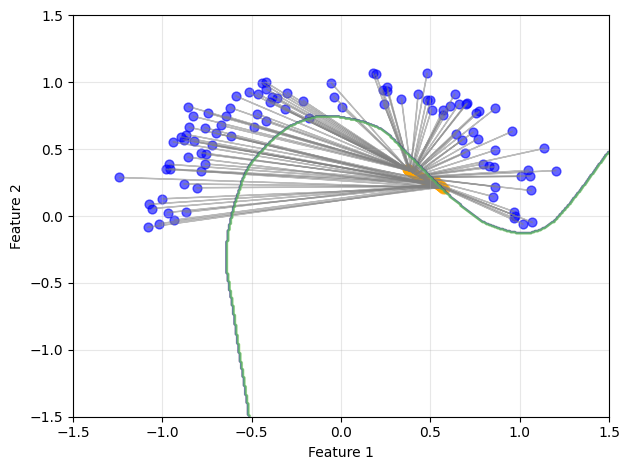

In [15]:
plot_counterfactuals(
    X_test_orig,
    results_arr,
    generative_model,
    discriminative_model,
    region_area_x=[-1.5, 1.5],
    region_area_y=[-1.5, 1.5],
)

# Method 3: GLOBE-CE (Global Counterfactual Explanations via Sampling)

## Reference
This method is inspired by global counterfactual explanation techniques that provide explanations for groups of instances rather than individual cases. The implementation is based on sampling-based approaches for generating global directional counterfactuals.

Related work:
- Upadhyay, S., Joshi, S., & Lakkaraju, H. (2021). *Towards Robust and Reliable Algorithmic Recourse*. In *Advances in Neural Information Processing Systems* (NeurIPS 2021). [AReS - Actionable Recourse Summaries]
- Dash, S., Günlük, O., & Wei, D. (2022). *Boolean Decision Rules via Column Generation*. In *Advances in Neural Information Processing Systems* (NeurIPS 2022).

## Description
GLOBE-CE is a **global counterfactual explanation** method that generates a unified translation vector (direction) that can be applied to multiple instances simultaneously. Unlike local methods that generate instance-specific counterfactuals, GLOBE-CE aims to find a single direction $\delta$ that, when scaled appropriately for each instance, produces valid counterfactuals.

The method operates through:
1. **Sampling**: Generate multiple candidate direction vectors by randomly sampling feature combinations
2. **Evaluation**: For each direction, evaluate its effectiveness across the affected population by:
   - Computing counterfactuals: $x_{cf}^{(i)} = x^{(i)} + k_i \cdot \delta$
   - Measuring validity (fraction achieving desired prediction)
   - Measuring cost (average distance to counterfactuals)
3. **Selection**: Choose the direction that maximizes coverage while minimizing average cost
4. **Scaling**: For each instance, find the optimal scalar $k_i$ that produces a valid counterfactual with minimal cost

This approach is particularly useful for providing actionable recourse to groups of individuals, as it identifies common directions for change.

## Mathematical Formulation

### Global Direction Search
The method seeks to find a global direction $\delta \in \mathbb{R}^d$ by maximizing:

$$
\delta^* = \arg\max_{\delta} \left\{ \text{Coverage}(\delta) - \lambda \cdot \text{Cost}(\delta) \right\}
$$

where:
- **Coverage**: Fraction of instances that achieve valid counterfactuals:
$$
\text{Coverage}(\delta) = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}[f(x^{(i)} + k_i^* \cdot \delta) = y_{\text{target}}]
$$

- **Cost**: Average distance to counterfactuals for valid cases:
$$
\text{Cost}(\delta) = \frac{1}{|\mathcal{V}|} \sum_{i \in \mathcal{V}} \|k_i^* \cdot \delta \circ c\|_1
$$

where $c$ is the feature cost vector and $\mathcal{V}$ is the set of instances with valid counterfactuals.

### Instance-Specific Scaling
For each instance $x^{(i)}$, find the optimal scalar:

$$
k_i^* = \arg\min_{k \geq 0} \left\{ \|k \cdot \delta \circ c\|_1 : f(x^{(i)} + k \cdot \delta) = y_{\text{target}} \right\}
$$

The final counterfactual is:
$$
x_{cf}^{(i)} = x^{(i)} + k_i^* \cdot \delta^*
$$

### Direction Sampling Scheme
Directions are sampled using:
$$
\delta = \frac{m \cdot \tilde{\delta}}{\|\tilde{\delta}\|_1 \cdot c}, \quad \tilde{\delta}_j \sim \text{Uniform}(0,1)^s
$$

where $m$ is the magnitude, $s$ is the sparsity power, and $c$ is the feature cost vector (inverse of bin widths for continuous features).


In [16]:
import importlib

GLOBE_CE = getattr(
    importlib.import_module("counterfactuals.cf_methods.global.globe_ce.globe_ce"),
    "GLOBE_CE",
)


def predict_fn(X: np.ndarray) -> np.ndarray:
    return discriminative_model.predict(X)


globe_ce = GLOBE_CE(
    discriminative_model=discriminative_model,
    dataset=dataset,
    X=X_test_orig,
)
counterfactuals_unscaled = globe_ce.get_counterfactuals()

100%|██████████| 1000/1000 [00:00<00:00, 10750.02it/s]

Unable to find recourse for 0/99 inputs


In [ ]:
ys_target = np.abs(1 - y_test_orig)


metrics_cf = MetricsOrchestrator(
    disc_model=discriminative_model,
    gen_model=generative_model,
    X_cf=counterfactuals_unscaled,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test_orig,
    y_test=y_test_orig,
    y_target=ys_target,
    continuous_features=[0, 1],
    categorical_features=[],
    ratio_cont=None,
    prob_plausibility_threshold=log_prob_threshold,
    metrics_conf_path=METRICS_CONF_PATH,
)
metrics = metrics_cf.calculate_all_metrics()

2025-10-17 11:27:29,946 - counterfactuals.metrics.orchestrator - INFO - Initialized MetricsOrchestrator with 99 counterfactuals, 99 valid


In [18]:
metrics

{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': 1.4083841314701424,
 'proximity_categorical_jaccard': 1.4083841314701424,
 'proximity_continuous_manhattan': 1.5234338752698129,
 'proximity_continuous_euclidean': 1.4083841314701424,
 'proximity_continuous_mad': 7.189334328709481,
 'proximity_l2_jaccard': 1.4083841314701424,
 'proximity_mad_hamming': 7.189334328709481,
 'prob_plausibility': 0.0,
 'log_density_cf': -691.6345,
 'log_density_test': -0.5425421,
 'lof_scores_cf': 20.91249731018034,
 'lof_scores_test': 7.465194310781295,
 'isolation_forest_scores_cf': -0.14203778815307214,
 'isolation_forest_scores_test': -0.09829707737692372}

/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/lukasz/genwro/counterfactuals/counterfactuals/plotting/counterfactual_visualization.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


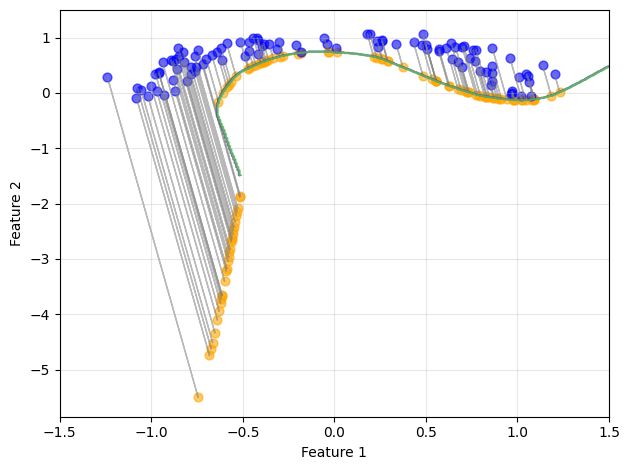

In [19]:
plot_counterfactuals(
    X_test_orig,
    counterfactuals_unscaled,
    generative_model,
    discriminative_model,
    region_area_x=[-1.5, 1.5],
    region_area_y=[-1.5, 1.5],
)